In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio

from pedalboard.pedalboard import load_plugin

import numpy as np
import librosa

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE

In [2]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda Overdrive"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/3kdv9ddi/checkpoints/epoch=820-step=513125.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]

In [3]:
# STFT condition
N_FFT = 4096
WIN_LEN = 2048
HOP_LEN = 2048

In [4]:
if DAFX_NAME.lower() == "clean":
    dafx = NullDAFXWrapper()
else:
    dafx = load_plugin(DAFX_FILE, plugin_name=DAFX_NAME)
    dafx = DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [5]:
dataset = PairedAudioDataset(
    dafx=dafx,
    audio_dir=AUDIO_DIR,
    subset="train",
    input_dirs=DATASETS,
    num_examples_per_epoch=NUM_EXAMPLES,
    augmentations={},
    length=131_072,
    effect_input=False,
    effect_output=True,
    dummy_setting=True
)

loader= torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    timeout=6000,
)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 43033.55it/s]


Loaded 88 files for train = 66.89 hours.


In [6]:
batch = next(iter(loader))
x, y = batch

In [7]:


def STFT(x):
    return torch.stft(x, n_fft=N_FFT, win_length=WIN_LEN, hop_length=HOP_LEN, window=torch.hann_window(WIN_LEN), return_complex=True)

def STFT_lib(x):
    return librosa.core.stft(x, n_fft=N_FFT, hop_length=HOP_LEN, win_length=WIN_LEN)

def iSTFT(x):
    return torch.istft(x, n_fft=N_FFT, win_length=WIN_LEN, hop_length=HOP_LEN)

def iSTFT_lib(x):
    return librosa.core.istft(x, n_fft=N_FFT, hop_length=HOP_LEN)

# def stft_zero_padd(data):
#     lf = len(data)
#     T = int(np.ceil((lf - WIN_LEN) / HOP_LEN))
#     lf_new = WIN_LEN + T * HOP_LEN
#     data = np.concatenate([data, np.zeros(lf_new-lf,)])
#     return data, lf_new

def mysign(x):
    return np.exp(1j * np.angle(x))

# # GLA
# def gla(z, amp, max_iter=100):
#     for i in range(max_iter):
#         x = amp * mysign(z)
#         istft = iSTFT(x)
#         z = STFT(istft)
#     return x


# Proposed algorithm by Masuyama et al.
def admm_gla(z, u, amp, max_iter=100, rho=0.01):
    for i in range(max_iter):
        x = amp * mysign(z - u)
        v = x + u
        z = (rho * v + STFT(iSTFT(v))) / (1 + rho)
    return x


In [8]:
def normalise_spectrogram(X_db):
    X_db_norm = X_db

    # Normalise (0,1)
    X_db_norm -= 0.3352797
    X_db_norm /= 0.2745147

    return X_db_norm

In [9]:
def denormalise_spectrogram(X_db_norm):
    # Denormalise
    X_db = X_db_norm
    X_db *= 0.2745147
    X_db += 0.3352797

    return X_db

In [10]:
def audio_to_spectrogram(signal, use_lib=False):
    if use_lib:
        X = torch.tensor(STFT_lib(signal.squeeze().numpy()))
    else:
        X = STFT(signal.squeeze())

    # Absolute value part
    X_db = torch.pow(X.abs() + 1e-8, 0.3)
    X_db_norm = normalise_spectrogram(X_db)

    X_db_norm = X_db_norm.permute(1, 0)

    return X_db_norm

In [11]:
def spectrogram_to_audio(spectrogram, use_lib=False):
     # Undo permutation
    X_db_norm = spectrogram.clone().detach().permute(1, 0).squeeze()

    # Denormalise
    X_db = denormalise_spectrogram(X_db_norm)
    X_db = torch.pow(X_db, 3) - 1e-8

    spec_shape = X_db.shape
    z0 = X_db * np.exp(2 * np.pi * 1j * np.random.rand(spec_shape[0],
                                                       spec_shape[1]))
    u0 = np.zeros(X_db.shape)

    x_admm_gla = admm_gla(z0, u0, X_db)

    # # Masuyama et al.
    # datar_admm_gla = iSTFT(x_admm_gla)

    if use_lib:
        datar_admm_gla = iSTFT_lib(x_admm_gla.squeeze().numpy())
    else:
        datar_admm_gla = iSTFT(x_admm_gla.squeeze())

    return datar_admm_gla

## Comparing PyTorch and Librosa (i)STFT

In [12]:
X_pytorch = audio_to_spectrogram(x, use_lib=False)

In [13]:
X_librosa = audio_to_spectrogram(x, use_lib=True)

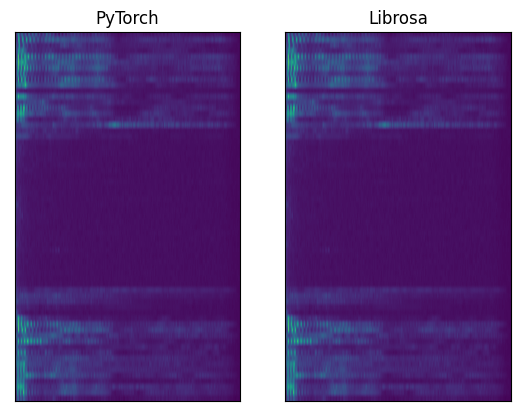

In [14]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(X_pytorch.squeeze(), aspect='auto')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("PyTorch")

ax[1].imshow(X_librosa.squeeze(), aspect='auto')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Librosa")

plt.show()

In [15]:
x_hat_pytorch = spectrogram_to_audio(X_pytorch, use_lib=False)

In [16]:
x_hat_librosa = spectrogram_to_audio(X_librosa, use_lib=True)

In [17]:
Audio(x.squeeze().numpy(), rate=SAMPLE_RATE)

In [18]:
Audio(x_hat_librosa, rate=SAMPLE_RATE)

In [19]:
Audio(x_hat_pytorch, rate=SAMPLE_RATE)

## Using iSTFT on Reconstructions

In [20]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT)
model.eval()

StyleTransferVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=20640, out_features=4096, bias=True)
  (log_var): Linear(in_features=2064

In [21]:
x_s = StyleTransferVAE.audio_to_spectrogram(signal=x, return_phase=False)
y_s = StyleTransferVAE.audio_to_spectrogram(signal=y, return_phase=False)

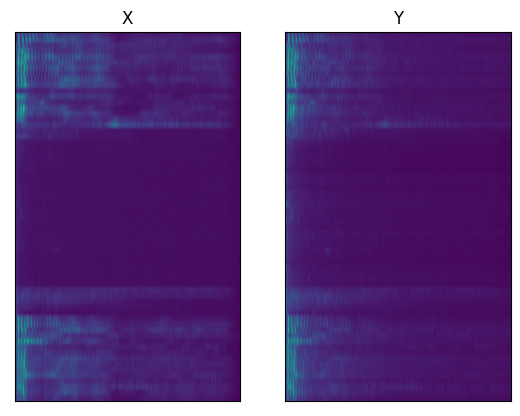

In [22]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(x_s.detach().numpy().squeeze(), aspect='auto')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("X")

ax[1].imshow(y_s.detach().numpy().squeeze(), aspect='auto')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Y")

plt.show()

In [23]:
X = torch.concat([x_s, y_s], dim=1)

In [24]:
X.shape

torch.Size([1, 2, 65, 2049])

### Get Reconstructions

In [25]:
X_hat, _, _, z = model(X)

### Clean Reconstructions

In [26]:
x_hat = X_hat[0,0,:,:]

In [27]:
x_istft = spectrogram_to_audio(audio_to_spectrogram(x, use_lib=False))

In [28]:
x_hat_istft = spectrogram_to_audio(x_hat)

In [29]:
Audio(x.numpy().squeeze(), rate=SAMPLE_RATE)

In [30]:
Audio(x_istft, rate=SAMPLE_RATE)

In [31]:
Audio(x_hat_istft.squeeze(), rate=SAMPLE_RATE)

### Effected Reconstructions

In [32]:
y_hat = X_hat[0,1,:,:]

In [33]:
y_istft = spectrogram_to_audio(audio_to_spectrogram(y, use_lib=False))

In [34]:
y_hat_istft = spectrogram_to_audio(y_hat)

In [35]:
Audio(y.numpy().squeeze(), rate=SAMPLE_RATE)

In [36]:
Audio(y_istft, rate=SAMPLE_RATE)

In [37]:
Audio(y_hat_istft.squeeze(), rate=SAMPLE_RATE)

## Save reconstruction images

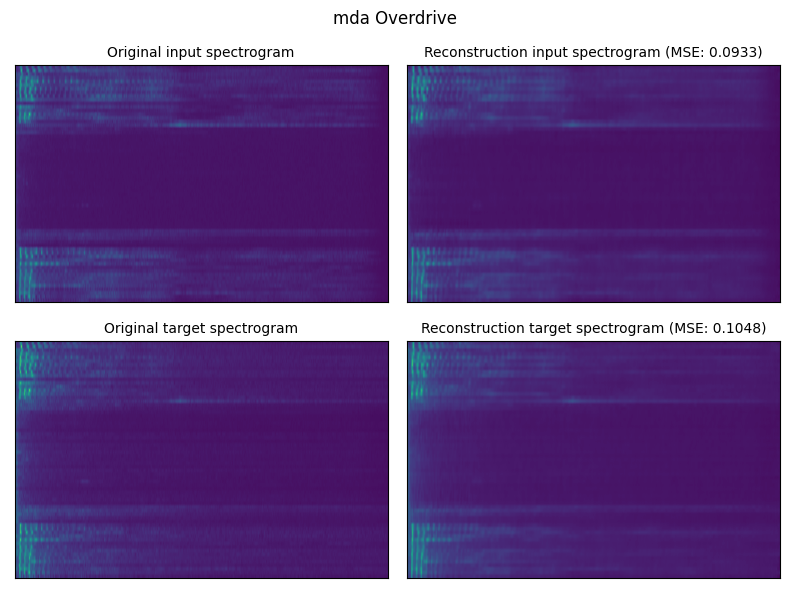

In [38]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8,6))

labels = ['input spectrogram', 'target spectrogram']

# find minimum of minima & maximum of maxima
minmin = min([torch.min(X).item(), torch.min(X_hat).item()])
maxmax = max([torch.max(X).item(), torch.max(X_hat).item()])

# for each dimension
for i in range(2):
    mse = F.mse_loss(X[0,i,:,:], X_hat[0,i,:,:])

    ax1 = axes[i, 0].imshow(X[0,i,:,:].detach().squeeze().numpy(),
                            aspect='auto',
                            vmin=minmin,
                            vmax=maxmax
                            )

    ax2 = axes[i, 1].imshow(X_hat[0,i,:,:].detach().squeeze().numpy(),
                            aspect='auto',
                            vmin=minmin,
                            vmax=maxmax
                            )

    axes[i, 0].set_title(f"Original {labels[i]}", fontsize=10)
    axes[i, 1].set_title(f"Reconstruction {labels[i]} (MSE: {mse.item():.4f})", fontsize=10)

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])


# plt.savefig("./figures/spectrogram_reconstruction_lo_kld.png")

# add space for colour bar
fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(ax2, cax=cbar_ax)
fig.suptitle(DAFX_NAME)

plt.tight_layout()
plt.savefig(f"./audio_files/{CHECKPOINT_ID}_{DAFX_NAME.split()[-1].lower()}_joint_recon_istft.svg")

## Save generated audio

In [39]:
import soundfile as sf

id_substring = f"audio_files/{CHECKPOINT_ID}_{DAFX_NAME.split()[-1].lower()}"

sf.write(f'{id_substring}_x.wav', x.numpy().squeeze(), SAMPLE_RATE)
sf.write(f'{id_substring}_x_istft.wav', x_istft.numpy().squeeze(), SAMPLE_RATE)
sf.write(f'{id_substring}_x_hat_istft.wav', x_hat_istft.numpy().squeeze(), SAMPLE_RATE)
sf.write(f'{id_substring}_y.wav', y.numpy().squeeze(), SAMPLE_RATE)
sf.write(f'{id_substring}_y_istft.wav', y_istft.numpy().squeeze(), SAMPLE_RATE)
sf.write(f'{id_substring}_y_hat_istft.wav', y_hat_istft.numpy().squeeze(), SAMPLE_RATE)